https://paperswithcode.com/dataset/oxford-102-flower

# Oxford 102 Flower

**oxford 102 flower** это датасет составленный для задач классификации, состоящий из 102 категорий цветов, в основном встречающихся на территории Великобритании. Каждый класс состоит от 40 до 258 картинок класса.

Картинки имеют достаточно большое разрешение, различные ракурсы, цветовые палитры и освещение. Плюсом к этому есть категории которые имеют сильно отличающиеся друг от друга картинки и несколько похожих категорий.

Изначально датасет был сформирован для задачи классификации по большому количеству классов, которые достаточно похожи.

## Визуализации

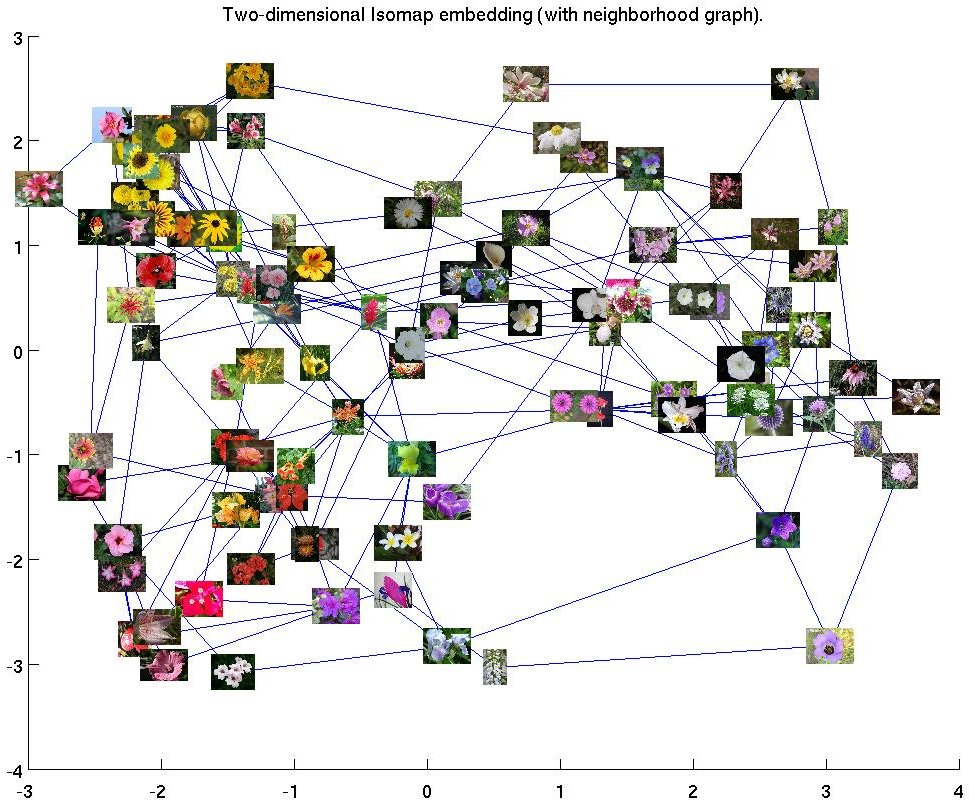
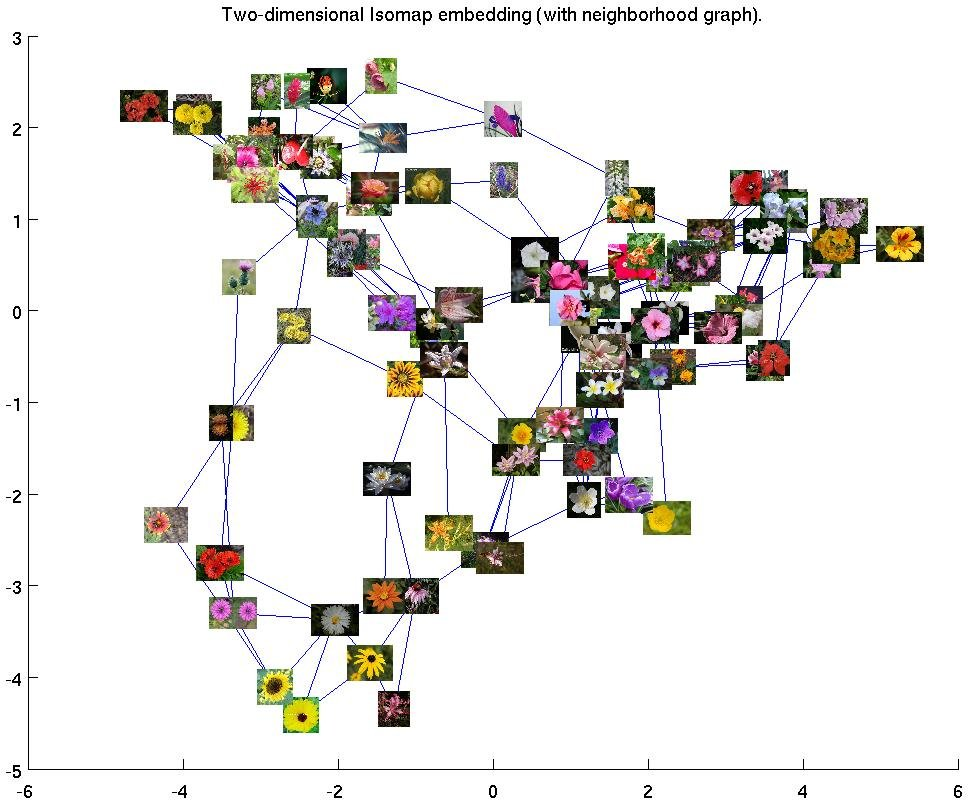

## Решаемые задачи

Согласно _paperswithcode.com_ датасет используется для следующих задач:
- Классификация изображений
- Генерация картинки по тексту
- Генерации картинок
- Инкрементальное обучение


Датасет представлен:
- 102 категории цветов (RGB картинки) + лейблы
- Маски сегментации

Однако маски нам не нужны, так что будем использовать версию датасета без них.

In [25]:
import tensorflow as tf
import tensorflow_hub as hub

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

In [2]:
tf_flowers_labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [3]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)

2022-12-25 13:23:49.611551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-25 13:23:49.611664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


Скачаем и разархивируем датасет

In [4]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [5]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

--2022-12-25 13:23:55--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.161.128, 173.194.73.128, 74.125.205.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.2’

ilsvrc2012_wordnet_ 100%[===================>]  21,17K  --.-KB/s    in 0,02s   

2022-12-25 13:23:55 (1,01 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.2’ saved [21675/21675]



In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

CLASS_NAMES = tf_flowers_labels  # from plotting helper functions above
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(data_dir.glob('*/*.jpg')))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  
  return tf.where(parts[-2] == CLASS_NAMES)[0][0]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  return img  

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  features = {'image': img, 'label': label}
  return features

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [7]:
def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [8]:
# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 

def show_preds(logits, image, correct_flowers_label=None, tf_flowers_logits=False):

  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_flowers_label is not None:
    ax1.set_title(tf_flowers_labels[correct_flowers_label])
  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    if not tf_flowers_logits:
      # predicting in imagenet label space
      classes.append(imagenet_int_to_str[j])
    else:
      # predicting in tf_flowers label space
      classes.append(tf_flowers_labels[j])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

In [9]:
print(data_dir)

/Users/ivanskvortsov/.keras/datasets/flower_photos


In [10]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"
imagenet_module = hub.KerasLayer(model_url)

2022-12-25 13:24:02.999627: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-25 13:24:03.003189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


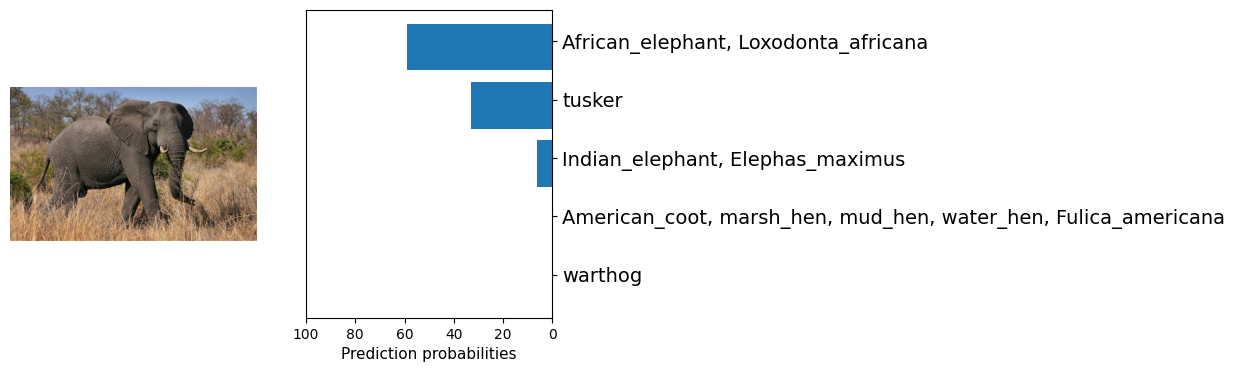

In [11]:
# Load image (image provided is CC0 licensed)
img_url = "http://images6.fanpop.com/image/photos/34700000/Grey-Elephant-colors-34712059-620-388.jpg"
image = load_image_from_url(img_url)

# Run model on image
logits = imagenet_module(image)

# Show image and predictions
show_preds(logits, image[0])

In [12]:
train_split = 0.9
num_train = int(train_split * num_examples)
ds_train = ds.take(num_train)
ds_test = ds.skip(num_train)

DATASET_NUM_TRAIN_EXAMPLES = num_examples

2022-12-25 13:24:06.231035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


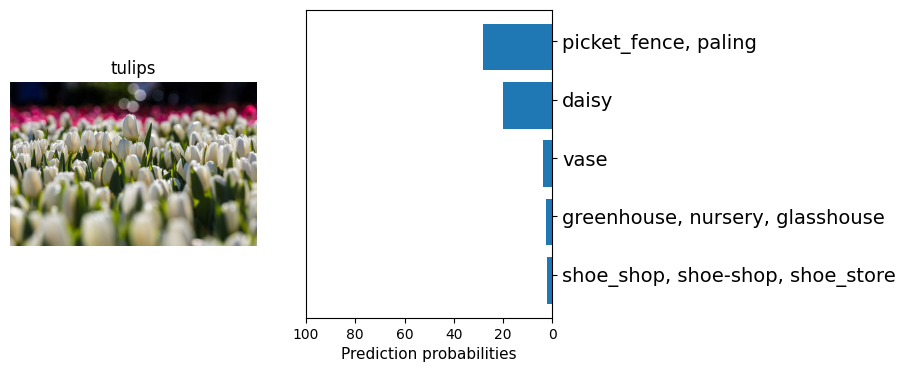

In [13]:
for features in ds_train.take(1):
  image = features['image']
  image = preprocess_image(image)

  # Run model on image
  logits = imagenet_module(image)
  
  # Show image and predictions
  show_preds(logits, image[0], correct_flowers_label=features['label'].numpy())

In [14]:
# Add new head to the BiT model

class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

In [15]:
IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [16]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 512
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [17]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [21]:
# model.compile(optimizer=optimizer,
#               loss=loss_fn,
#               metrics=['accuracy'])

# # Fine-tune model
# history = model.fit(
#     pipeline_train,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     epochs= 10,
#     validation_data=pipeline_test
# )

Epoch 1/10


2022-12-25 13:24:41.281201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8436

2022-12-25 13:25:09.787203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 36s 3s/step - loss: 0.4042 - accuracy: 0.8436 - val_loss: 0.0934 - val_accuracy: 0.9728
Epoch 2/10
10/10 [==============================] - 30s 3s/step - loss: 0.1595 - accuracy: 0.9514 - val_loss: 0.2003 - val_accuracy: 0.9428
Epoch 3/10
10/10 [==============================] - 25s 3s/step - loss: 0.1522 - accuracy: 0.9596 - val_loss: 0.1224 - val_accuracy: 0.9591
Epoch 4/10
10/10 [==============================] - 24s 2s/step - loss: 0.1224 - accuracy: 0.9648 - val_loss: 0.0974 - val_accuracy: 0.9700
Epoch 5/10
10/10 [==============================] - 26s 3s/step - loss: 0.1074 - accuracy: 0.9689 - val_loss: 0.0880 - val_accuracy: 0.9700
Epoch 6/10
10/10 [==============================] - 23s 2s/step - loss: 0.0861 - accuracy: 0.9738 - val_loss: 0.0508 - val_accuracy: 0.9782
Epoch 7/10
10/10 [==============================] - 26s 3s/step - loss: 0.0712 - accuracy: 0.9771 - val_loss: 0.0514 - val_accuracy: 0.9891
Epoch 8/10
10/10 [=============

In [22]:
# Save fine-tuned model as SavedModel
# export_module_dir = './tmp/my_saved_bit_model/'
# tf.saved_model.save(model, export_module_dir)

INFO:tensorflow:Assets written to: ./tmp/my_saved_bit_model/assets


INFO:tensorflow:Assets written to: ./tmp/my_saved_bit_model/assets


In [23]:
saved_module = hub.KerasLayer(export_module_dir, trainable=True)

2022-12-25 13:43:27.811187: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 're_lu_48/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 2 outputs. Output shapes may be inaccurate.
2022-12-25 13:43:27.811221: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'global_average_pooling2d/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 4 outputs. Output shapes may be inaccurate.


2022-12-25 13:43:36.637416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


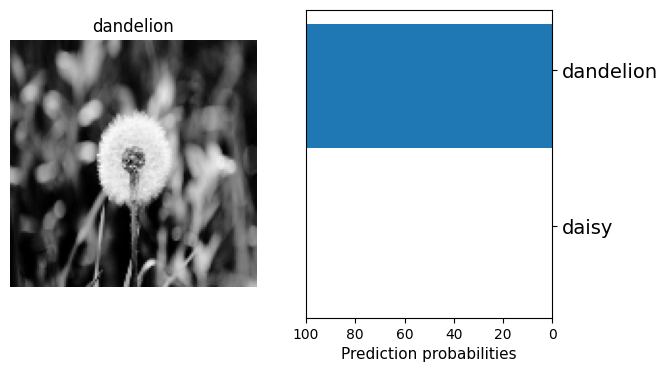

In [24]:
for features in ds_train.take(1):
  image = features['image']
  image = preprocess_image(image)
  image = tf.image.resize(image, [CROP_TO, CROP_TO])

  # Run model on image
  logits = saved_module(image)
  
  # Show image and predictions
  show_preds(logits, image[0], correct_flowers_label=features['label'].numpy(), tf_flowers_logits=True)